In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def get_filenames(results_dir, precond = None):
    if precond is None:
        return os.listdir(results_dir), None
    else:
        names = []
        precond_list = []
        for type in precond:
            try:
                precond_names = os.listdir(os.path.join(results_dir, type))
            except FileNotFoundError: # If the preconditioner type is not present as a file (could occur due to divergence), skip it
                continue
            names.extend(precond_names)
            precond_list.extend(len(precond_names) * [type])
        return names, precond_list

In [3]:
# Gets the results for a given dataset + optimizer combination
def load_results(results_dir, dataset, opt, precond = None):
    results = {}
    results_dir = os.path.join(results_dir, dataset, opt)
    filenames, precond_list = get_filenames(results_dir, precond) # If preconditioner list is given, get filenames for the preconditioners in that order

    if opt in ['svrg', 'saga', 'lkatyusha', 'slbfgs']:
        for filename in filenames:
            if filename.endswith('.csv'):
                start = filename.find('_') + len('_')
                end = filename.find('_seed_')
                hyperparam = filename[start:end] # Get lr or L; we assume the hyperparameter only appears once across all files in the folder
                df = pd.read_csv(os.path.join(results_dir, filename))
                results[hyperparam] = df
    elif opt.startswith('sketchy'):
        for filename, preconditioner in zip(filenames, precond_list):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(results_dir, preconditioner, filename))
                results[preconditioner] = df # We assume the preconditioner only appears once across all files in the folder

    return results

In [4]:
# Get the best training loss run for a given dataset and optimizer combination
def get_best_run(results):
    best_loss = np.Inf
    best_param = None
    for param in list(results.keys()):
        # Get the best attained final loss during training and the corresponding hyperparameter
        loss = np.nanmin(results[param]['train_loss'].values)
        if loss < best_loss:
            best_loss = loss
            best_param = param
    return best_param, results[best_param]

In [5]:
def get_loss_dfs(results_dir, opts, dataset, auto_only):
    loss_dfs = {}
    opts_new = []

    for opt in opts:
        if isinstance(opt, tuple): # Preconditioned
            results = load_results(results_dir, dataset, opt[0], [opt[1]])
            loss_dfs[opt] = results[opt[1]]
            opts_new.append(opt)
        else: # Not preconditioned
            results = load_results(results_dir, dataset, opt)

            if auto_only: # Remove everything but auto from results
                if 'auto' in results.keys():
                    results = {key: results[key] for key in results.keys() if key == 'auto'}
                    _, df = get_best_run(results)
                    loss_dfs[opt] = df
                    opts_new.append(opt)
            else: # Remove auto from results
                results = {key: results[key] for key in results.keys() if key != 'auto'}
                _, df = get_best_run(results)
                loss_dfs[opt] = df
                opts_new.append(opt)

    return loss_dfs, opts_new

In [6]:
# Get the minimum loss across all optimizers given dataframes of losses
def get_min_loss(loss_dfs, opts_new):
    min_loss = np.Inf
    for opt in opts_new:
        min_loss = min(min_loss, np.nanmin(loss_dfs[opt]['train_loss'].values))
    return min_loss

In [7]:
def get_opt_precond_name(opt):
    if isinstance(opt, tuple):
        opt_name = opt[0]
        precond_name = opt[1]
    else:
        opt_name = opt
        precond_name = None
    
    return opt_name, precond_name

In [8]:
def get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names):
    if opt_name.startswith('sketchy'):
        linestyle = 'solid'
        marker = markers[precond_name]
        color = colors[opt_name]
        label = f"{opt_plot_names[opt_name]} ({precond_plot_names[precond_name]})"
    else:
        linestyle = 'dashed'
        marker = None
        color = colors[opt_name]
        label = opt_plot_names[opt_name]

    return linestyle, marker, color, label

In [9]:
def get_legend(results_keys, markers, colors, opt_plot_names, precond_plot_names):
    from matplotlib.lines import Line2D 
    legend_elements = []
    for opt in list(results_keys):
        opt_name, precond_name = get_opt_precond_name(opt)
        linestyle, marker, color, label = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)
        legend_elements.append(Line2D([0], [0], color=color, label=label, linestyle = linestyle, marker = marker))
    return legend_elements

In [10]:
def format_plot(dataset, ylims, xaxis, axes):
    axes.set_title(dataset, fontsize=14)
    axes.set_ylim(ylims)
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.tick_params(axis='both', which='minor', labelsize=10)
    axes.set_xlabel(xaxis['label'], fontsize=14)

In [11]:
def save(directory, fig_name, fig):
    plt.figure(fig)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(os.path.join(directory, fig_name), bbox_inches='tight')

In [12]:
def subopt_plot(results_dir, dataset, opts, xaxis, colors, markers, opt_plot_names, precond_plot_names, ylim, auto_only = False):
    loss_dfs, opts_new = get_loss_dfs(results_dir, opts, dataset, auto_only)
    min_loss = get_min_loss(loss_dfs, opts_new)

    plt.figure()

    zorder = lambda key: 1 if isinstance(key, tuple) else 2

    for key in opts_new:
        opt_name, precond_name = get_opt_precond_name(key)
        linestyle, marker, color, label = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)
            
        x = None
        if xaxis['name'] == 'time':
            x = np.cumsum(loss_dfs[key]['times'].values)
        elif xaxis['name'] == 'full_gradients':
            x = np.arange(1, len(loss_dfs[key]['train_loss'].values) + 1)
            if opt_name in ['svrg', 'lkatyusha', 'slbfgs', 'sketchysvrg', 'sketchykatyusha']:
                x = x * 2

        plt.semilogy(x, loss_dfs[key]['train_loss'].values - min_loss, label = label,
                      color = color, linestyle = linestyle, marker = marker, markevery = 10, zorder = zorder(key))
    
    plt.ylim(ylim)
    plt.xlabel(xaxis['label'])
    plt.ylabel('Suboptimality')
    plt.title(dataset)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

In [13]:
def subopt_plot_datasets_xaxes(results_dir, datasets, problem_type, opts, xaxes, colors, markers, opt_plot_names, precond_plot_names, ylims, save_dir, plot_name, auto_only = False):
    n_datasets = len(datasets)
    n_xaxes = len(xaxes)
    fig, axes = plt.subplots(n_xaxes, n_datasets, figsize = (n_datasets*4, n_xaxes*3))

    zorder = lambda key: 1 if isinstance(key, tuple) else 2

    for i, (dataset, ylim) in enumerate(zip(datasets, ylims)):
        loss_dfs, opts_new = get_loss_dfs(results_dir, opts, dataset, auto_only)
        min_loss = get_min_loss(loss_dfs, opts_new)
        
        for j, xaxis in enumerate(xaxes):
            subplot_idx = j * n_datasets + i

            if i == 0 and j == 0:
                legend_elements = get_legend(opts_new, markers, colors, opt_plot_names, precond_plot_names)

            for key in opts_new:
                opt_name, precond_name = get_opt_precond_name(key)
                linestyle, marker, color, label = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)

                x = None
                if xaxis['name'] == 'time':
                    x = np.cumsum(loss_dfs[key]['times'].values)
                elif xaxis['name'] == 'full_gradients':
                    x = np.arange(1, len(loss_dfs[key]['train_loss'].values) + 1)
                    if opt_name in ['svrg', 'lkatyusha', 'slbfgs', 'sketchysvrg', 'sketchykatyusha']:
                        x = x * 2

                axes.flat[subplot_idx].semilogy(x, loss_dfs[key]['train_loss'].values - min_loss, label = label,
                    color = color, linestyle = linestyle, marker = marker, markevery = 10, zorder = zorder(key))

            format_plot(dataset, ylim, xaxis, axes.flat[subplot_idx])
    
    fig.tight_layout(pad=2.0)
    fig.legend(handles = legend_elements, loc = 'upper center', 
            bbox_to_anchor = (0.5, 0.00), ncol=3, fontsize=14)
    fig.text(0, 0.5, 'Suboptimality', va='center', rotation='vertical', fontsize=14)

    fig_name = f'{problem_type}_subopt_combined_{plot_name}.pdf'
    save(save_dir, fig_name, fig)

In [14]:
results_dir = '../suboptimality_results'
opts = ['svrg', 'saga', 'slbfgs', 'lkatyusha',
        ('sketchysvrg', 'ssn'), ('sketchysvrg', 'nystrom'),
        ('sketchysaga', 'ssn'), ('sketchysaga', 'nystrom'),
        ('sketchykatyusha', 'ssn'), ('sketchykatyusha', 'nystrom')]
opts_2 = [('sketchysgd', 'ssn'), ('sketchysgd', 'nystrom'),
        ('sketchysvrg', 'ssn'), ('sketchysvrg', 'nystrom'),
        ('sketchysaga', 'ssn'), ('sketchysaga', 'nystrom'),
        ('sketchykatyusha', 'ssn'), ('sketchykatyusha', 'nystrom')]
colors = {'svrg': 'tab:blue', 'saga': 'tab:orange', 'slbfgs': 'tab:brown', 'lkatyusha': 'tab:pink',
        'sketchysgd': 'tab:red', 'sketchysvrg': 'tab:blue',
        'sketchysaga': 'tab:orange', 'sketchykatyusha': 'tab:pink'}
opt_plot_names = {'sgd': 'SGD', 'svrg': 'SVRG', 'saga': 'SAGA', 'slbfgs': 'SLBFGS', 'lkatyusha': 'L-Katyusha',
                'sketchysgd': 'SketchySGD', 'sketchysvrg': 'SketchySVRG',
                'sketchysaga': 'SketchySAGA', 'sketchykatyusha': 'SketchyKatyusha'}
precond_plot_names = {'nystrom': 'NySSN', 'ssn': 'SSN'}
markers = {'nystrom': '^', 'ssn': '*'}
xaxes = [{'name': 'time', 'label': 'Wall-clock time (s)'}, {'name': 'full_gradients', 'label': 'Full data passes'}]
save_dir = './suboptimality'

In [15]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

## All tuned

### Logistic

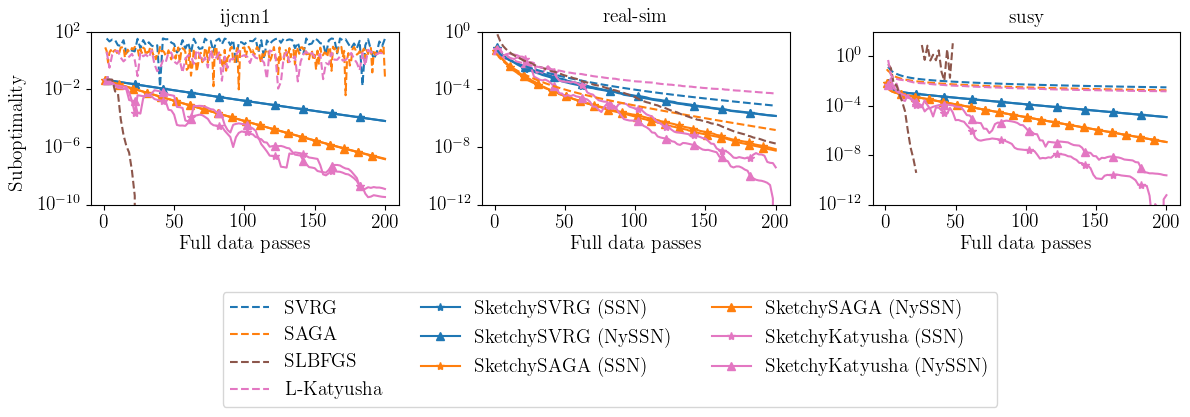

In [16]:
datasets = ['ijcnn1', 'real-sim', 'susy']
problem_type = 'logistic'
label = 'main'
ylims = [(1e-10, 1e2), (1e-12, 1e0), (1e-12, 1e2)]
subopt_plot_datasets_xaxes(results_dir, datasets, problem_type, opts, [xaxes[1]], colors, markers,
                           opt_plot_names, precond_plot_names, ylims, save_dir, label, auto_only = False)

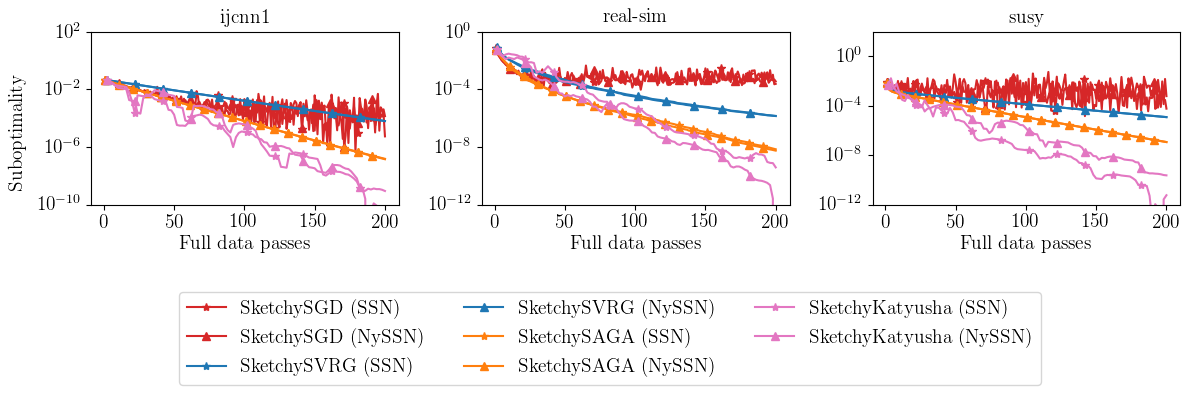

In [17]:
datasets = ['ijcnn1', 'real-sim', 'susy']
problem_type = 'logistic'
label = 'appdx'
ylims = [(1e-10, 1e2), (1e-12, 1e0), (1e-12, 1e2)]
subopt_plot_datasets_xaxes(results_dir, datasets, problem_type, opts_2, [xaxes[1]], colors, markers,
                           opt_plot_names, precond_plot_names, ylims, save_dir, label, auto_only = False)

### Least squares

/var/folders/bf/sk55r6n92bb0ygz11stdyclc0000gn/T/ipykernel_15004/4006783599.py:7: RuntimeWarning: All-NaN slice encountered
  loss = np.nanmin(results[param]['train_loss'].values)
/var/folders/bf/sk55r6n92bb0ygz11stdyclc0000gn/T/ipykernel_15004/4006783599.py:7: RuntimeWarning: All-NaN slice encountered
  loss = np.nanmin(results[param]['train_loss'].values)
/var/folders/bf/sk55r6n92bb0ygz11stdyclc0000gn/T/ipykernel_15004/4006783599.py:7: RuntimeWarning: All-NaN slice encountered
  loss = np.nanmin(results[param]['train_loss'].values)
/var/folders/bf/sk55r6n92bb0ygz11stdyclc0000gn/T/ipykernel_15004/4006783599.py:7: RuntimeWarning: All-NaN slice encountered
  loss = np.nanmin(results[param]['train_loss'].values)
/var/folders/bf/sk55r6n92bb0ygz11stdyclc0000gn/T/ipykernel_15004/4006783599.py:7: RuntimeWarning: All-NaN slice encountered
  loss = np.nanmin(results[param]['train_loss'].values)
/var/folders/bf/sk55r6n92bb0ygz11stdyclc0000gn/T/ipykernel_15004/4006783599.py:7: RuntimeWarning: Al

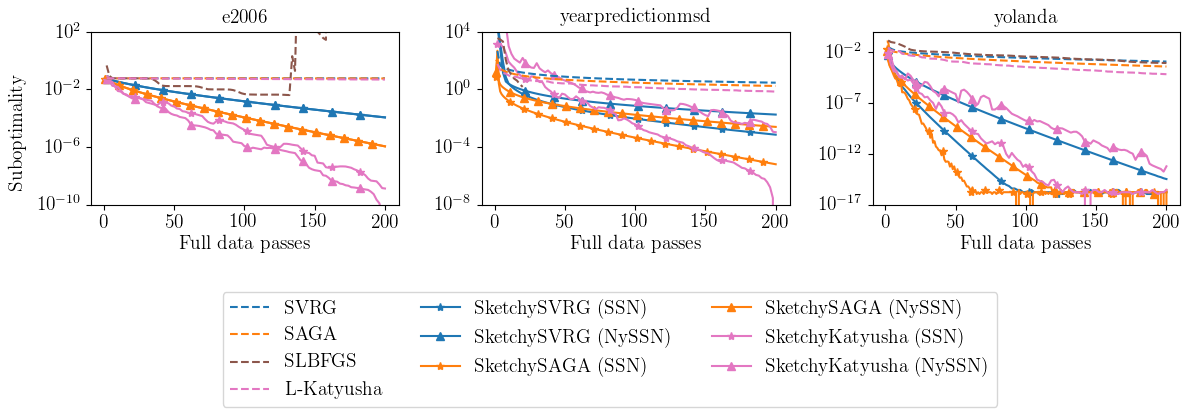

In [20]:
datasets = ['e2006', 'yearpredictionmsd', 'yolanda']
problem_type = 'least_squares'
label = 'main'
ylims = [(1e-10, 1e2), (1e-8, 1e4), (1e-17, 1e0)]
subopt_plot_datasets_xaxes(results_dir, datasets, problem_type, opts, [xaxes[1]], colors, markers,
                           opt_plot_names, precond_plot_names, ylims, save_dir, label, auto_only = False)

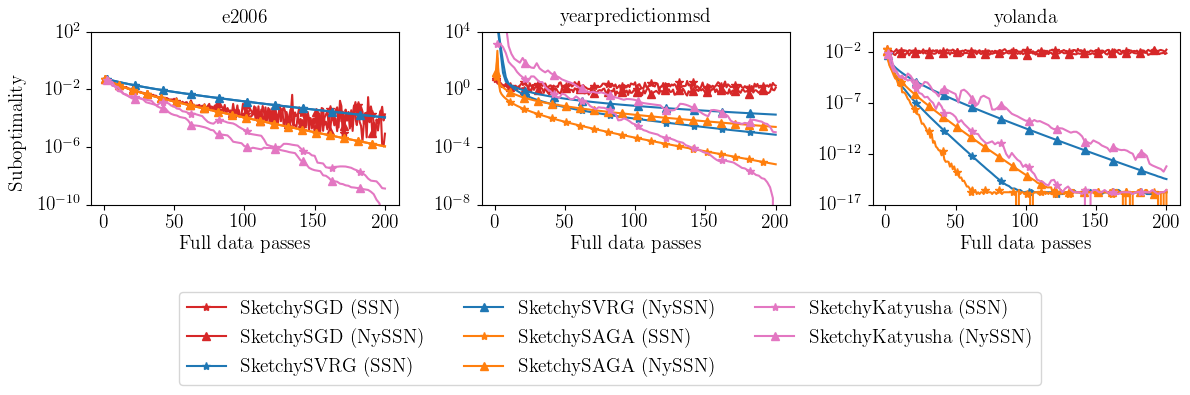

In [21]:
datasets = ['e2006', 'yearpredictionmsd', 'yolanda']
problem_type = 'least_squares'
label = 'appdx'
ylims = [(1e-10, 1e2), (1e-8, 1e4), (1e-17, 1e0)]
subopt_plot_datasets_xaxes(results_dir, datasets, problem_type, opts_2, [xaxes[1]], colors, markers,
                           opt_plot_names, precond_plot_names, ylims, save_dir, label, auto_only = False)